# WDL 2021 - Stage 3: Predicting the demand for shared bicycles

# Introduction

Intro

SOA

A nossa abordagem (resumo)

Problemas encontrados (resumo)

A nossa solução (resumo)

Notas: A nossa solução inicial assumia que era possível fazer o tracing das bicicletas, mas após ser fornecido o dicionário, percebemos que tal não era possível dado que "The same bike can have multiple tags over the year".

# Data pre-processing

Explicar o que foi limpo, etc. e justificar. (RESUMO)

Guardamos o df pre-processado e por isso pode-se só executar o código a partir do cap Exploratory data analysis

## Import libraries and customize seaborn

In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import floor
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (15,12)

base = '/home/ana/Downloads/'
#base = r'C:\Users\Carolina Alves\OneDrive - Universidade de Aveiro\WDL competition\Stage 3'

Using TensorFlow backend.


## Auxiliar functions

In [2]:
# bar plot function
def bar_plot(_x, _y, _data):
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x=_x, y=_y, data=_data)
    plt.xticks(rotation=90)
    plt.draw()
    
# performs the encoding of categorical features to ordinal numbers
def encode_categorical_features(_df, features):
    df = _df.copy()
    enc = OrdinalEncoder()
    df[features] = enc.fit_transform(df[features]).astype(int)
    
    return enc, df

## Loading the dataset

In [ ]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
df = pd.read_csv(base+'/'+"bike_loans.csv", sep=";")
pickle.dump(df, open(base+'/'+"df_raw", "wb"))

In [ ]:
# Opening data
df = pickle.load(open(base+'/'+"df_raw", "rb" ))

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.shape

## Data types, uniques and NaN information 

For each column, check type of data, number of unique values and the presence of missing values

In [ ]:
def eda_to_df(df):
    header="+" + ("-"*85) + "+"
    form = "|{:^25s}|{:^10s}|{:^10s}|{:^10s}|{:^15s}|{:^10s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?", "Number of NaN" ,"%NaN"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), # Column
                          str(df[col].dtypes), # Type
                          str(len(df[col].unique())), # Uniques
                          str(df[col].isnull().values.any()), # NaN?
                          str(df[col].isnull().sum()), # Number of NaNs
                          str(round(((df[col].isnull().sum())/len(df[col]))*100,5)) )) # %NaN
    print(header)

eda_to_df(df)

[ANÁLISE TABELA]

Importe e DescripcionImporte têm apenas um valor que se repete em todas as linhas e por isso são removidos

In [ ]:
df = df.drop(['Importe', 'DescripcionImporte'], axis=1)

***Looking for relations between NaN values in columns Id_Aparcamiento_Destino, Posicion_Destino and operario***

In [ ]:
df_apar_destino = df[df['Id_Aparcamiento_Destino'].isnull()]
print('Number of NaN in Id_Aparcamiento_Destino column: ', len(df_apar_destino))

df_pos_destino = df[df['Posicion_Destino'].isnull()]
print('\nNumber of NaN in Posicion_Destino column: ', len(df_pos_destino))

df_pos_apar = df[(df['Id_Aparcamiento_Destino'].isnull()) & (df['Posicion_Destino'].isnull())]
print('\nNumber of rows when Id_Aparcamiento_Destino and Posicion_Destino are NaN: ', len(df_pos_apar))

df_pos_apar_ope = df[(df['Id_Aparcamiento_Destino'].isnull()) & (df['Posicion_Destino'].isnull()) & (df['operario']=='monitor')]
print('\nNumber of rows when Id_Aparcamiento_Destino and Posicion_Origen are NaN and the operario is monitor: ', len(df_pos_apar_ope))

df_pos_apar_ope_null = df[(df['Id_Aparcamiento_Destino'].isnull()) & (df['Posicion_Destino'].isnull()) & (df['operario'].isnull())]
print('\nNumber of rows when Id_Aparcamiento_Destino, Posicion_Origen and operario are NaN: ', len(df_pos_apar_ope_null))

In [ ]:
df_apar_destino.head()

Quando o Id_Aparcamiento_Destino tem valores NaN não conseguimos saber qual a estação de destino. Por essa razão esses dados não nos interessam pois não trazem informação ao modelo que irá ser construído. 

In [ ]:
df = df[df['Id_Aparcamiento_Destino'].notna()]

***Calculating the usage duration of bicycles***

In [ ]:
def duration (prestamo, devolucion):

    start = datetime.datetime.strptime(prestamo[0:19], "%Y-%m-%d %H:%M:%S")
    end = datetime.datetime.strptime(devolucion[0:19], "%Y-%m-%d %H:%M:%S")
    time = end - start
    seconds = time.total_seconds()

    return seconds

In [ ]:
df['Duration'] = df.apply(lambda x: duration(x['Fecha_Prestamo'],x['Fecha_Devolucion']),axis=1)

***Removing data when the usage duration of bicycles is negative (which means that the day of prestamo is after the day of devolucion)***

In [ ]:
df = df[df['Duration']>60]

***Removing data before 2016 and after 2020***

In [ ]:
def select_data_between(df, year_init, year_end):

    df_list = []
    increment = 1000000
    for i in range(0,15000000, increment):
        df_ = df.iloc[i:i+increment,:]
        #creating column with the year of prestamo and devolucion
        df_['Year_Prestamo'] = df_.apply(lambda x: year_(x['Fecha_Prestamo']),axis=1) 
        df_['Year_Devolucion'] = df_.apply(lambda x: year_(x['Fecha_Devolucion']),axis=1) 
        #removing years before year_init and after year_end
        df_= df_[(df_['Year_Prestamo']>=year_init) & (df_['Year_Prestamo']<year_end)]
        df_= df_[(df_['Year_Devolucion']>=year_init) & (df_['Year_Devolucion']<year_end)]
        df_list.append(df_)

    #creating cleaned dataframe
    df_new_ = pd.DataFrame()
    df_clean_ = df_new_.append(other=df_list,ignore_index=True)

    return df_clean_

df_clean_ = select_data_between(df, 2016, 2020)

#confirming
print(df_clean_['Year_Prestamo'].unique())
print(df_clean_['Year_Devolucion'].unique())

In [ ]:
df_clean_.head()

***Encoding categorical features***

In [ ]:
print('Number of NaN in column Id_Tag_Bicicleta: ', df_clean_['Id_Tag_Bicicleta'].isnull().sum())
print('\nNumber of NaN in column operario: ', df_clean_['operario'].isnull().sum())

In [ ]:
operario_ = df_clean_['operario'].fillna(value='other')
df_clean_['operario'] = operario_

In [ ]:
enc, df_clean_ = encode_categorical_features(df_clean_, ["Id_Tag_Bicicleta", "operario"])
df_clean_.head()

In [ ]:
#Saving cleaned dataframe
pickle.dump(df_clean_, open(path+'/'+"df_clean", "wb" ))

# Exploratory Data Analysis

In [3]:
def get_loans_clean(base):

    df = pd.read_pickle(base + 'df_clean')[["Id_Historico_Prestamo", "Id_Usuario", "Id_Tag_Bicicleta", \
            "Fecha_Prestamo", "Fecha_Devolucion", "Id_Aparcamiento_Origen", "Posicion_Origen", \
            "Id_Aparcamiento_Destino", "Posicion_Destino"]]
    
    # Rename columns
    # The same bike can have multiple tags over the year.
    df = df.rename(columns={
        "Id_Historico_Prestamo": "Loan ID",
        "Id_Usuario": "User ID",
        "Id_Tag_Bicicleta": "Tag ID",
        "Fecha_Prestamo": "Start loan",
        "Fecha_Devolucion": "End loan",
        "Id_Aparcamiento_Origen": "ID start station",
        "Posicion_Origen": "Position start",
        "Id_Aparcamiento_Destino": "ID end station",
        "Posicion_Destino": "Position end"
    })
    
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df["End loan"] = pd.to_datetime(df["End loan"], format='%Y-%m-%d %H:%M:%S.%f')
    
    # Auxiliar fields
    df['year_prestamo'] = df["Start loan"].dt.year
    df['month_prestamo'] = df["Start loan"].dt.month
    df['day_prestamo'] = df["Start loan"].dt.day
    df['hour_prestamo'] = df["Start loan"].dt.hour
    
    df['year_devolucion'] = df["End loan"].dt.year
    df['month_devolucion'] = df["End loan"].dt.month
    df['day_devolucion'] = df["End loan"].dt.day
    df['hour_devolucion'] = df["End loan"].dt.hour
    
    df['duration_hour'] = (df["End loan"]-df["Start loan"]).dt.total_seconds().div(60*60)
    df['Fecha_Prestamo_htruncate'] = df['Start loan'].dt.floor('h')
        
    return df

df = get_loans_clean(base)
df.head()

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end,year_prestamo,month_prestamo,day_prestamo,hour_prestamo,year_devolucion,month_devolucion,day_devolucion,hour_devolucion,duration_hour,Fecha_Prestamo_htruncate
0,6501462,18701,1164,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,2017,6,21,14,2017,6,21,14,0.271667,2017-06-21 14:00:00
1,6501318,41811,1089,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,2017,6,21,14,2017,6,21,14,0.530000,2017-06-21 14:00:00
2,6501489,96620,1110,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,2017,6,21,14,2017,6,21,14,0.232222,2017-06-21 14:00:00
3,6501001,16055,1465,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,2017,6,21,13,2017,6,21,14,1.058333,2017-06-21 13:00:00
4,6501421,6431,996,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,2017,6,21,14,2017,6,21,14,0.358333,2017-06-21 14:00:00


Stations information

## External data

### Stations location

In [4]:
df_info = pd.read_csv("station_location_with_id.csv", sep=';')[['ID','numSlots','isManual']]
df_info.head()

,ID,numSlots,isManual
0,1,15,1
1,2,33,1
2,3,40,0
3,4,10,1
4,5,33,1


Ver a capacidade de armazenamento das estações automáticas. Quais são as estações automáticas com maior capacidade de armazenamento? Quais as com menor?

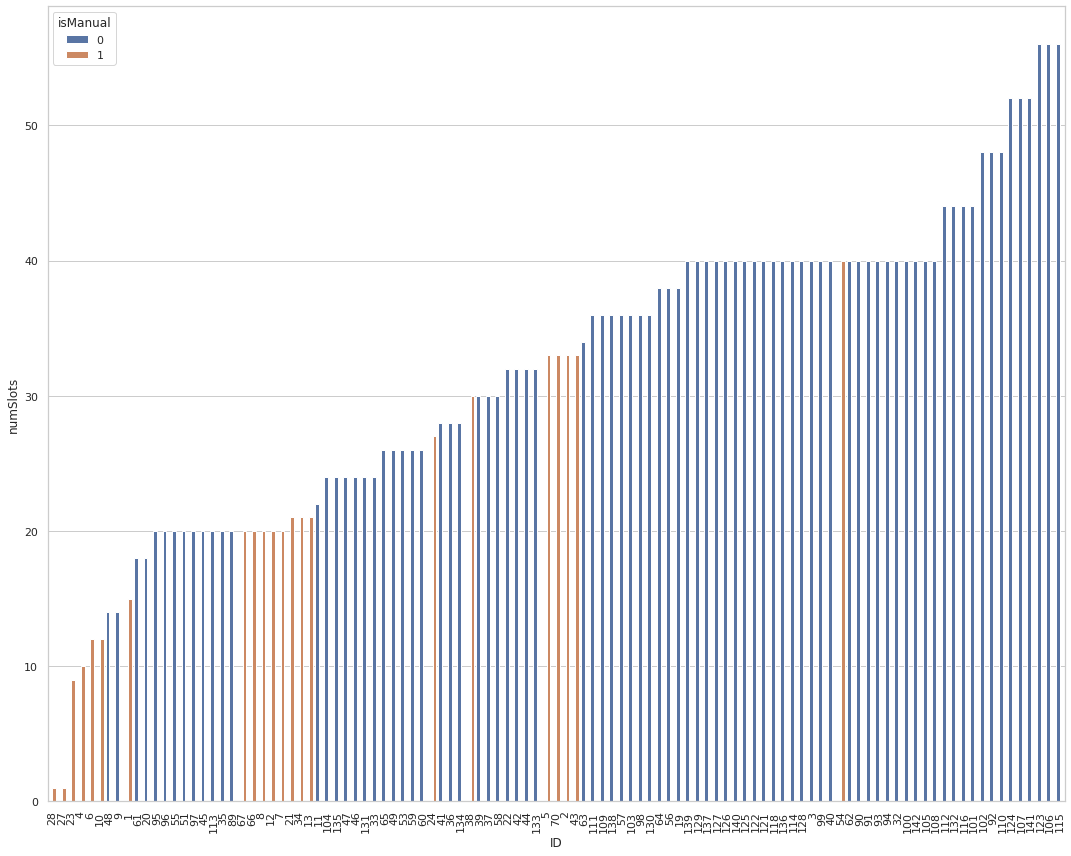

In [5]:
def capacity_per_station(_df):
    df = _df.copy()
    df["ID"] = df["ID"].astype(str)
    df = df.sort_values(by=['numSlots'])
    
    fig, axs = plt.subplots(figsize=(15,12))
    axs = sns.barplot(x="ID", y="numSlots", hue="isManual", data=df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.draw()
    
capacity_per_station(df_info)

É possivel vizualizar que as estações manuais existem em menor quantidade que as automáticas...

### Holidays

In [6]:
def get_holidays():
    holidays16 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2016')
    holidays17 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2017')
    holidays18 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2018')
    holidays19 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2019')
    holidays = pd.concat([holidays16, holidays17, holidays18, holidays19])
    return holidays

holidays = get_holidays()
holidays.head()

,DAY,DATE,HOLIDAY
0,Friday,2016-01-01,New Year's Day
1,Monday,2016-01-11,Epiphany
2,Monday,2016-03-21,Saint Joseph's Day
3,Thursday,2016-03-24,Maundy Thursday
4,Friday,2016-03-25,Good Friday


In [7]:
df.head()

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end,year_prestamo,month_prestamo,day_prestamo,hour_prestamo,year_devolucion,month_devolucion,day_devolucion,hour_devolucion,duration_hour,Fecha_Prestamo_htruncate
0,6501462,18701,1164,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,2017,6,21,14,2017,6,21,14,0.271667,2017-06-21 14:00:00
1,6501318,41811,1089,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,2017,6,21,14,2017,6,21,14,0.530000,2017-06-21 14:00:00
2,6501489,96620,1110,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,2017,6,21,14,2017,6,21,14,0.232222,2017-06-21 14:00:00
3,6501001,16055,1465,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,2017,6,21,13,2017,6,21,14,1.058333,2017-06-21 13:00:00
4,6501421,6431,996,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,2017,6,21,14,2017,6,21,14,0.358333,2017-06-21 14:00:00


In [8]:
def plot_loans_per_day_versus_holidays(_df, holidays):
    df = _df.copy()
    df['DATE'] = df['Start loan'].dt.date.astype(str)
    dfDATE_count = df.groupby('DATE').size().reset_index(name='count')
    
    holidays_count = pd.merge(dfDATE_count,holidays,on='DATE')

    fig, ax = plt.subplots(figsize=fig_dim)
    sns.lineplot(data=dfDATE_count, x="DATE", y="count", ax=ax, label="Number of loads per day")
    sns.regplot(data=holidays_count, x="DATE", y="count", fit_reg=False, 
                scatter_kws={"color":"black","alpha":1,"s":50}, ax=ax, label='Holidays')
    
plot_loans_per_day_versus_holidays(df, holidays)

Error in callback <function flush_figures at 0x7f2e6b49f830> (for post_execute):


KeyboardInterrupt: 

Na maior parte em que a contagem é muito baixa coincide com os feriados. Dado que a maior parte ads estações são automáticas, isto significa que, o mais provável é, mesmo as estaões automáticas fecham em determinados dias (tais como os feriados)

## Evolution of loans, returns, stations... over time

***Quais são as horas/dias da semana/meses mais comuns para usar uma bicicleta?***

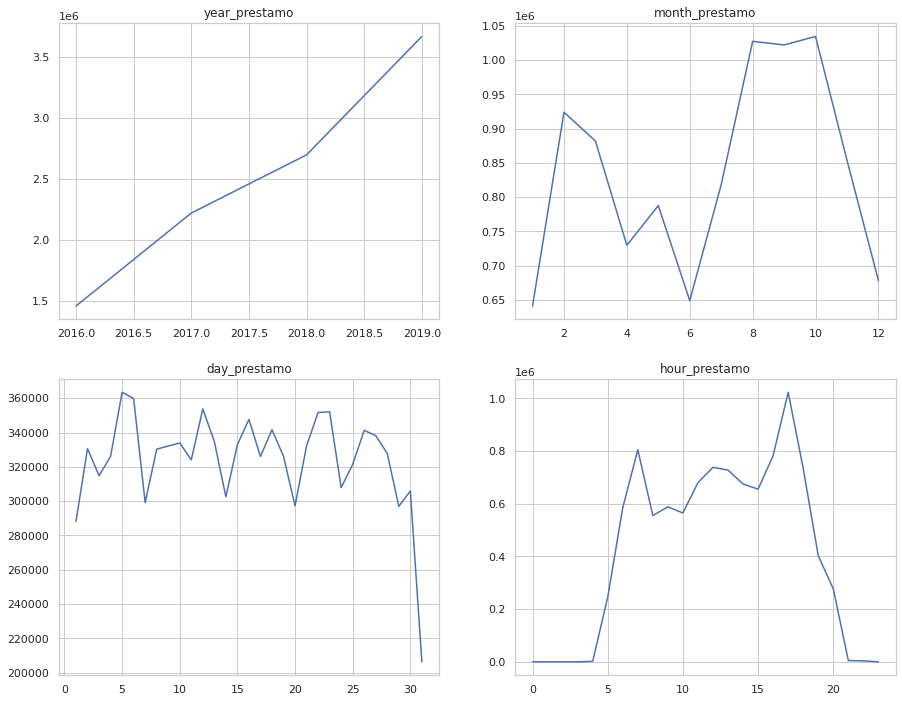

In [9]:
def plot_prestamo_over_time(_df):
    df = _df.copy()
    
    fig, axs = plt.subplots(2, 2, figsize=fig_dim)
    axis = [ axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
    
    time_units = ["year", "month", "day", "hour"]
    
    for i in range(len(time_units)):
        time_unit = time_units[i]
        df_time = df.groupby(time_unit+'_prestamo').size().reset_index(name='count')

        axis[i].plot(df_time[time_unit+"_prestamo"], df_time["count"])
        axis[i].set_title(time_unit+"_prestamo")

    plt.plot()

plot_prestamo_over_time(df)

Over the years, the number of loans increased. 

Existem meses com um maior volume de empréstimos, nomeadamente Agosto, set., out. 
Estes são meses de férias... por isso é esperado um maior nº de turistas????
Os meses de fevereiro, março, julho e novembro tb verificam um elevado nº de empréstimos.

Relativamente aos dias, os valores são similares, havendo pequenas oscilações. Para o dia 31 verifica-se uma grande diminuição dado que existe um menor nº de meses com 31 dias.

Hour: Existem dois picos que se destacam, sendo estes coincidentes com o rush hour (um no periodo ao inicio da manhã  e outro ao fim do dia). Também existe um pico à hora de almoço. As estações devem de abrir Às 4h e fechar Às ?22? dado qque o nº de empréstimos antes e depois é 0.

***Quais é que são os tempos médios de empréstimo?***

In [ ]:
dfDuration=df.groupby('duration_hour').size().reset_index(name='count')
ax=dfDuration.plot(x="duration_hour", y="count", figsize=(16,9))
ax.set_xscale('log')

In [ ]:
dfDuration_ft = dfDuration[(dfDuration["duration_hour"]<0.2) & (dfDuration["duration_hour"]>0.05)]
ax=dfDuration_ft.plot(x="duration_hour", y="count", figsize=(16,9))

Como podemos ver, o topo da curva é atingido entre os 0.10 e 0.12 da hora, i.e., entre os 6 e 8 minutos.

***Quais as origens/destinos mais comuns***

In [ ]:
dfOrigin=df.groupby('ID start station').size().reset_index(name='count').sort_values(by=['count'])    
dfOrigin["ID start station"] = dfOrigin["ID start station"].astype(str)
bar_plot("ID start station", "count", dfOrigin)

O gráfico dá-nos as origens mais comuns. Várias estações são muito pouco utilizadas, da estação 73 à 105 (pela ordem representada no gráfico). 

In [ ]:
dfOrigin.head(25)

In [ ]:
dfDestination=df.groupby('ID end station').size().reset_index(name='count').sort_values(by=['count'])    
dfDestination["ID end station"] = dfDestination["ID end station"].astype(str)
bar_plot("ID end station", "count", dfDestination)

Quais os trajetos mais comuns?

In [ ]:
def plot_popular_routes(df):
    
    df_routes = df.groupby(['ID start station', 'ID end station']).size().reset_index(name='count')

    fig = plt.figure(figsize=fig_dim)
    ax = Axes3D(fig)

    ax.plot_trisurf(df_routes["ID start station"], df_routes["ID end station"], \
                    df_routes["count"], cmap=cm.jet, linewidth=0.2)
    ax.set_zlabel('Count')
    ax.set_xlabel('Origin')
    ax.set_ylabel('Destination')

    plt.show()
    
plot_popular_routes(df)

In [ ]:
# justificar porque é que só usamos os desta coluna
unique_parks = df['ID start station'].unique()
unique_parks

Para cada nó, as datas/dias e a contagem do check-in (empréstimos).

In [ ]:
dfOrigemDayCount=df.groupby(["ID start station", pd.Grouper(key="Fecha_Prestamo_htruncate", freq="D")]) \
                        .size().reset_index(name='Count')
dfOrigemDayCount.head()

In [ ]:
# TO-DO
# gráfico
# após a previsão encontrar o dia com mais nós em que foi realizada a previsão

# nº de nós associados ao dia
dfNodesDay = dfOrigemDayCount.groupby("Fecha_Prestamo_htruncate").size().reset_index() \
    .rename(columns={0:'count'}).sort_values(by=['count'])

dfNodesDay.tail()

In [ ]:
def active_stations_per_day(_df):
    df = _df.copy().sort_values(by=['Fecha_Prestamo_htruncate'])
    fig = plt.figure(figsize=fig_dim)
    plt.plot(df["Fecha_Prestamo_htruncate"], df["count"])

active_stations_per_day(dfNodesDay)

Isto dá-nos a data com mais nós associados mas não garante que os 85 nós tem 4 entradas antes

In [ ]:
def loans_per_day_per_station(_df, station):
    df = _df.copy()
    df = df[df["ID start station"]==station]
    df = df[["Fecha_Prestamo_htruncate", "Count"]]
    
    fig = plt.figure(figsize=fig_dim)
    plt.plot(df["Fecha_Prestamo_htruncate"], df["Count"])

loans_per_day_per_station(dfOrigemDayCount, 1)

In [ ]:
loans_per_day_per_station(dfOrigemDayCount, 70)

Loans per station per hour

In [ ]:
def get_loans_or_returns_per_station_per_time(_df, field_date, field_station, field_position, time):
    df = _df.copy()
    df = df[[field_date, field_station, field_position]]
    df[field_position] = [1]*len(df.index)
    #df[field_date] = df[field_date].dt.round(time)
    
    if time == 'd':
        df[field_date] = df[field_date].dt.date
    elif time == 'h':
        df[field_date] = df[field_date].dt.floor('h')

    df = df.rename(columns={field_date:'Date', field_station:'Station'})
    df = df.groupby(['Station', 'Date']).size().to_frame()
    
    if(field_date=='Start loan'):
        df = df.rename(columns={0:'N Loans'})
    else:
        df = df.rename(columns={0:'N Returns'})
        
    return df

def get_loans_and_returns_info_per_time(_df, time):
    loans = get_loans_or_returns_per_station_per_time(_df, \
                    'Start loan', 'ID start station', 'Position start', time)
        
    returns = get_loans_or_returns_per_station_per_time(_df, \
                    'End loan', 'ID end station', 'Position end', time)
        
    df = pd.concat([loans, returns], axis=1)
    df = df.fillna(0)
    df['balance_per_' + time] = df['N Returns'] - df['N Loans']
    
    return df

In [ ]:
loans_and_returns = get_loans_and_returns_info_per_time(df, "h")
loans_and_returns.head(5)

In [ ]:
# Given a station, this function calculates the number of bikes through time using the loans and the returns
def get_balance_for_station(_df, station):
    df = _df.copy()
    df = df.reset_index()
    df = df.loc[df['Station']==station]
    df['N Loans cumsum'] = df['N Loans'].cumsum()
    df['N Returns cumsum'] = df['N Returns'].cumsum() # returns
    df['Balance'] = df['N Returns cumsum'] - df['N Loans cumsum']
    
    return df

In [ ]:
def plot_balance_over_multiple_stations(loans_and_returns, stations):
    
    fig, axs = plt.subplots(4, 2, figsize=(15,24))
    axis = [ axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1],
             axs[2, 0], axs[2, 1], axs[3, 0], axs[3, 1]]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i in range(8):
        station = stations[i]
    
        balance_st = get_balance_for_station(loans_and_returns, station)
        
        axis[i].plot(balance_st['Date'], balance_st['Balance'], colors[i])
        axis[i].set_title('Station ' + str(station))
        axis[i].tick_params(labelrotation=30)

    plt.plot()

plot_balance_over_multiple_stations(loans_and_returns, stations=[1, 70, 54, 45, 12, 70, 2, 21])

Dizer o que significa as subidas, descidas e estabilizações - recebm mais do que emprestam, emprestam mais do que receber e recebem e emprestam na mesma porporção (respetivamente)
Através do balanço não dá para perceber qual o número de bicicletas inicial da estação, porque esistem várias trocas manuais que não são reportadas.

In [ ]:
# TO-DO
# gráfico
# após a previsão encontrar o dia com mais nós em que foi realizada a previsão

Obter o número inicial de bicicletas por estação

In [ ]:
# ver o primeiro mês em que a estação abre, e fazer a contagens por aí

def get_init_number_of_bikes_per_station(_df):
    df = _df.copy()
    df = df[["Tag ID", "Start loan", "ID start station"]]
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.sort_values(by="Start loan")
    # for each tag get first station
    df = df.groupby("Tag ID").first() \
            .reset_index() \
            [["Tag ID", "ID start station"]]
    # for each station get initial number of bikes 
    df = df.groupby("ID start station").count()
    df = df.rename(columns={'Tag ID':'Count'})
    df = df.sort_values(by=['Count'])
    df = df.reset_index()
    df["ID start station"] = df["ID start station"].astype(str)
    return df
    
init_n_bikes = get_init_number_of_bikes_per_station(df)
init_n_bikes.head()

In [ ]:
fig, axs = plt.subplots(figsize=fig_dim)
axs = sns.barplot(x="ID start station", y="Count", data=init_n_bikes)
plt.xticks(rotation=90)
plt.draw()

The figure above represents the number of bikes that appear for the first time in each station

A estação 9 está associada ao aparecimento pela primeira vez de 400 bicicletas (do ID de uma bicicleta).

[BRUNO] Qual é a localização das estações com mais de 100 contagens? 

Verificar quando as estações automáticas cheias. -> ver para cada estação qual o nº máximo de posições diferentes e depois tentar perceber qnd é que elas estão cheias (elas estão cheias se num dado intervalo de tempo todas as positions estão ocupadas) ---> taxa de ocupação

Há posições que nunca são ocupadas!!!!

Ver a taxa de ocupação a cada hora

# Forecasting the ?field?

In [ ]:
dfOrigemDayCount.head()

In [ ]:
loans_and_returns_per_day = get_loans_and_returns_info_per_time(df, "d")
loans_and_returns_per_day.head(25)

In [ ]:
def get_max_balance_per_day(_df):
    df = _df.copy()
    df = get_loans_and_returns_info_per_time(df, "h")
    df = df.reset_index()
    df["Date"] = df["Date"].dt.date
    df = df.groupby(['Station', 'Date']).max().rename(
        columns={"N Loans": "max_n_loans", "N Returns": "max_n_returns", "balance_per_h": "max_balance_per_h"})
    df['max_balance_per_h'] = [0 if x<0 else x for x in df['max_balance_per_h']]
    return df
    
loans_and_returns_max_per_day = get_max_balance_per_day(df)
loans_and_returns_max_per_day.head()

In [ ]:
# ver parâmetros para melhorar, 
# se o count_before for 8 ele dá 8 entradas antes
# offset é o nº de dias antes do atual
# distância entre cada uma das entradas
# distance=1, count_before=3, offset=0 ---> considera os 3 dias antes
# distance=7, count_before=4, offset=7 ---> 4 entradas com a diferença de 7 dias entre elas 
#                                              e começo a contar na semana anterior

In [ ]:
# Auxiliar functions
def generate_features(df, cols, distance=1, count_before=3, offset=0):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance+offset)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for col in cols:
        for i in range(0, count_before):
            diff=(i+1)*distance+offset
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], \
                                                               axis=1) 
        
    return periodDf

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test, dfFeatures):
    trainX = train[dfFeatures.columns[4:]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[["Count"]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[dfFeatures.columns[4:]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[["Count"]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=2, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=6, kernel_size=2, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    min_score=-1
    min_model=None
    # repeat experiment
    scores = list()
    for r in range(repeats):
        print("Train #{}....".format(r))
        model, score = evaluate_model(trainX, trainy, testX, testy)
        if min_score==-1 or score<min_score:
            min_score=score
            min_model=model
        scores.append(score)
    return min_model, scores

In [ ]:
def perform_forecasting_all_nodes(_df, parks):
    
    df = _df.copy()

    allNodesDf=pd.DataFrame()
    # CREATE MODEL PER NODE AND PREDICT TEST SET BASED ON EACH INDIVIDUAL MODEL
    for park in parks:
        # FILTERING ENTRIES TO PARK ID
        print ("Filtering entries by park id {}...".format(park))
        dfParkId = df[df["ID start station"]==park]
        dfParkId=dfParkId.reset_index()

        # GENERATE FEATURES (4 ENTRIES 7 DAYS APPART FROM EACH OTHER FROM THE PREVIOUS 4 WEEKS)
        print ("Generating park {} features...".format(park))
        dfFeatures=generate_features(dfParkId, ["Count"], distance=7, count_before=4, offset=7)
        dfFeatures=dfFeatures.reset_index(drop=True)

        # SPLITTING DF INTO TRAIN AND TEST SETS
        print ("Splitting train/test dataset for park id {}...".format(park))
        train, test = split_df(dfFeatures)
        trainX, trainy, testX, testy = process_df(train, test, dfFeatures)

        # TRAIN CNN
        print ("Traning model for park id {}...".format(park))
        model, scores = run_experiment(trainX, trainy, testX, testy, repeats=3)

        # PREDICT TEST SET SAMPLES
        print ("Predicting samples for park id {}...".format(park))
        predict = model.predict(testX)
        dfPredict=pd.DataFrame(data=predict.flatten()[:], columns=["predict"])
        truth=pd.DataFrame(data=testy[:], columns=["truth"])
        testDf=pd.concat([dfPredict, truth, test.reset_index()[["ID start station", "Fecha_Prestamo_htruncate"]]], \
                         axis=1)
        testDf.set_index(["ID start station", "Fecha_Prestamo_htruncate"], inplace = True)
        allNodesDf=pd.concat([allNodesDf, testDf])
        print(allNodesDf)
        
    return allNodesDf

# perform_forecasting_all_nodes(dfOrigemDayCount, unique_parks)
allNodesDf = perform_forecasting_all_nodes(dfOrigemDayCount, [8, 56])

## Overall results

In [ ]:
rms = np.sqrt(mean_squared_error(allNodesDf["truth"], allNodesDf["predict"]))
print ("OVERALL ROOT MEAN SQUARED ERROR >> " + str(rms))

for node in unique_parks:
    print (" ------------------ NODE {} TRUTH VS PREDICTED CHECK INS ------------------ ".format(node))
    ax=allNodesDf.loc[node].plot(figsize=fig_dim, title='Predicted vs ground truth number of infractions over time (for test set)')

    ax.set_xlabel("Date")
    ax.set_ylabel("Number of infractions")
    plt.show()

# Load Balancing

# Conclusions

## Scalability and Impact

## Future Work

# References